# Finding Similar Items: Textually Similar Documents

## Imports

In [1]:
import findspark
findspark.init()

from pyspark import *
from pyspark.sql.functions import desc, col, rand
from pyspark.sql import *
from graphframes import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

import os
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import sys
from sympy.ntheory.generate import nextprime
import time

from utils import DataReader, make_heatmap
from classes import Shingling, Vectorizer, CompareSets, MinHashing, CompareSignatures, LSH, \
    FindTextuallySimilarDocuments

In [2]:
%load_ext autoreload
%autoreload 2

Set the environment variable to get consistent results with the built-in hash function.

In [3]:
%env PYTHONHASHSEED 0

env: PYTHONHASHSEED=0


In [4]:
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

Setup PySpark for Jupyter Noteobook.

In [5]:
# https://graphframes.github.io/graphframes/docs/_site/quick-start.html
# https://stackoverflow.com/questions/65011599/how-to-start-graphframes-on-spark-on-pyspark-on-juypter-on-docker
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell'
os.environ['PYSPARK_PYTHON'] = sys.executable

## Code

Start Spark session and record time since epoch for plotting etc.

In [6]:
spark = SparkSession.builder.appName('hw1').getOrCreate()
epoch_time = int(time.time())

21/11/12 20:25:12 WARN Utils: Your hostname, mark-machine resolves to a loopback address: 127.0.1.1; using 130.237.2.19 instead (on interface wlp8s0)
21/11/12 20:25:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mark/.ivy2/cache
The jars for the packages stored in: /home/mark/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-61e3ce11-09d6-423b-962e-f86e404e2a4d;1.0
	confs: [default]
	found graphframes#graphframes;0.8.1-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 156ms :: artifacts dl 8ms
	:: modules in use:
	graphframes#graphframes;0.8.1-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-------------------------------------

## Download data

http://mlg.ucd.ie/datasets/bbc.html

In [7]:
%%bash
file=./data/bbc-fulltext.zip

if [ -e "$file" ]; then
    echo "$file exists, skipping"
else 
    echo "$file does not exist, using wget to download it"
    wget http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip -P data/
    unzip $file -d data/
fi

./data/bbc-fulltext.zip exists, skipping


In [8]:
data_path = "data/bbc/"
topic_names = ["business", "entertainment", "politics", "sport", "tech"]

data_reader = DataReader(data_path=data_path, spark=spark)
df_data_all = data_reader(topic_names=topic_names)
df_data_all = df_data_all.select("id","topic","path","text")
df_data_all.show()

skipping data/bbc/sport/199.txt due to: 'utf-8' codec can't decode byte 0xa3 in position 257: invalid start byte


+---+--------+--------------------+--------------------+
| id|   topic|                path|                text|
+---+--------+--------------------+--------------------+
|  0|business|data/bbc/business...|Criminal probe on...|
|  1|business|data/bbc/business...|'Post-Christmas l...|
|  2|business|data/bbc/business...|Beijingers fume o...|
|  3|business|data/bbc/business...|Jobs growth still...|
|  4|business|data/bbc/business...|Winn-Dixie files ...|
|  5|business|data/bbc/business...|US economy still ...|
|  6|business|data/bbc/business...|Wall Street cheer...|
|  7|business|data/bbc/business...|China now top tra...|
|  8|business|data/bbc/business...|US to probe airli...|
|  9|business|data/bbc/business...|India unveils ant...|
| 10|business|data/bbc/business...|Train strike grip...|
| 11|business|data/bbc/business...|China had role in...|
| 12|business|data/bbc/business...|Dollar gains on G...|
| 13|business|data/bbc/business...|Euro firms miss o...|
| 14|business|data/bbc/business

In [9]:
limit_to = 20
df_data = df_data_all.limit(limit_to)
df_data.show()
df_data_collected = df_data.collect()
#data = data_all.orderBy(rand(seed=1234)).limit(limit_to)

+---+--------+--------------------+--------------------+
| id|   topic|                path|                text|
+---+--------+--------------------+--------------------+
|  0|business|data/bbc/business...|Criminal probe on...|
|  1|business|data/bbc/business...|'Post-Christmas l...|
|  2|business|data/bbc/business...|Beijingers fume o...|
|  3|business|data/bbc/business...|Jobs growth still...|
|  4|business|data/bbc/business...|Winn-Dixie files ...|
|  5|business|data/bbc/business...|US economy still ...|
|  6|business|data/bbc/business...|Wall Street cheer...|
|  7|business|data/bbc/business...|China now top tra...|
|  8|business|data/bbc/business...|US to probe airli...|
|  9|business|data/bbc/business...|India unveils ant...|
| 10|business|data/bbc/business...|Train strike grip...|
| 11|business|data/bbc/business...|China had role in...|
| 12|business|data/bbc/business...|Dollar gains on G...|
| 13|business|data/bbc/business...|Euro firms miss o...|
| 14|business|data/bbc/business

In [10]:
print(f"data.shape = {df_data.count(), len(df_data.columns)}")

data.shape = (20, 4)


## Shingling

In [11]:
k = 10
texts_rdd = df_data.select("text").rdd.flatMap(lambda x:x)
shingling = Shingling(k=k)
k_shingles_rdd, k_shingles_all_rdd = shingling(texts_rdd=texts_rdd)
n_shingles = k_shingles_all_rdd.count()
print(f"Found n_shingles={n_shingles} distinct shingles across all docs with k={k}")
prime_modulo = nextprime(n_shingles)

Found n_shingles=37936 distinct shingles across all docs with k=10


In [12]:
vectorizer = Vectorizer()
k_shingles_vectorized_rdd = \
    vectorizer(k_shingles_rdd=k_shingles_rdd, k_shingles_all_rdd=k_shingles_all_rdd)

In [33]:
len(k_shingles_vectorized_rdd.take(1)[-1])

37936

In [13]:
compare_sets = CompareSets()
js_rdd = compare_sets(k_shingles_vectorized_rdd=k_shingles_vectorized_rdd)

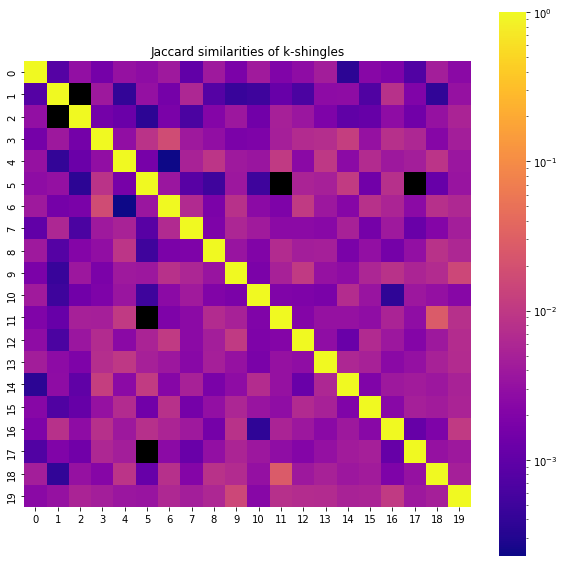

In [14]:
js_rdd_collected = js_rdd.collect()
make_heatmap(js_rdd_collected, "Jaccard similarities of k-shingles", epoch_time)

In [34]:
js_rdd_collected[11]

[(0, 0.0019347037484885128),
 (1, 0.0011418783899514702),
 (2, 0.004890544946436889),
 (3, 0.0046443412368614035),
 (4, 0.010502625656414103),
 (5, 0.0),
 (6, 0.0018542555164101613),
 (7, 0.0025614754098360654),
 (8, 0.0067026624464717926),
 (9, 0.004962779156327543),
 (10, 0.0019553072625698325),
 (11, 1.0),
 (12, 0.002153316106804479),
 (13, 0.003216726980297547),
 (14, 0.003205128205128205),
 (15, 0.002745367192862045),
 (16, 0.005393478793822015),
 (17, 0.0027685492801771874),
 (18, 0.026589242053789732),
 (19, 0.0076937511728279225)]

## MinHashing

In [15]:
n_signatures = 100
seed = 32
min_hashing = MinHashing(n_signatures=n_signatures, prime_modulo=prime_modulo, seed=seed)
signatures_rdd = min_hashing(k_shingles_vectorized_rdd=k_shingles_vectorized_rdd)

In [16]:
compare_signatures = CompareSignatures()
signature_similarities_rdd = compare_signatures(signatures_rdd=signatures_rdd)

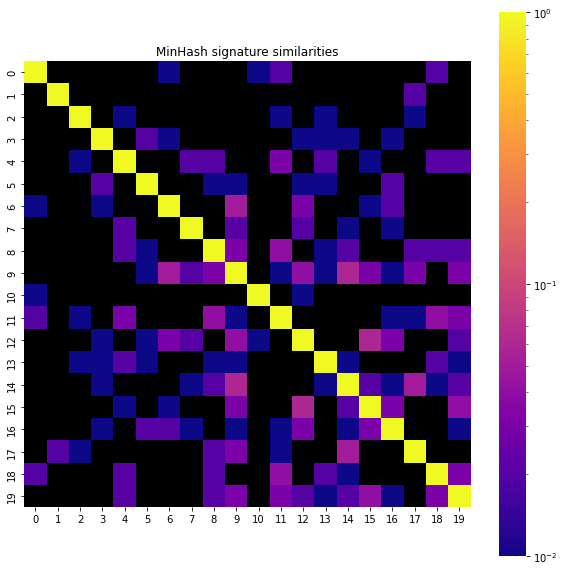

In [17]:
signature_similarities_rdd_collected = signature_similarities_rdd.collect()
make_heatmap(signature_similarities_rdd_collected, "MinHash signature similarities", epoch_time)

In [37]:
signature_similarities_rdd_collected[11]

[(0, 0.02),
 (1, 0.0),
 (2, 0.01),
 (3, 0.0),
 (4, 0.03),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.04),
 (9, 0.01),
 (10, 0.0),
 (11, 1.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.0),
 (16, 0.01),
 (17, 0.01),
 (18, 0.04),
 (19, 0.03)]

## Locally Sensitive Hashing (LSH)

In [18]:
n_bands = 5
n_buckets = 20

lsh = LSH(n_signatures=n_signatures, n_bands=n_bands, n_buckets=n_buckets)
print(lsh)
candidates_rdd = lsh(signatures_rdd=signatures_rdd)

LSH:
n_signatures=100
n_bands=5
n_buckets=20
n_rows_per_band=20
sim_thresh=0.9226808345905884
hash_to_n_min=1



In [19]:
df_candidates = candidates_rdd.toDF(["id", "candidates"])

df = \
    df_data.\
    join(df_candidates, df_data["id"] == df_candidates["id"], "outer").\
    drop(df_candidates.id).\
    sort("id", ascedning=True)

df.show()

+---+--------+--------------------+--------------------+--------------------+
| id|   topic|                path|                text|          candidates|
+---+--------+--------------------+--------------------+--------------------+
|  0|business|data/bbc/business...|Criminal probe on...|[0, 4, 11, 13, 14...|
|  1|business|data/bbc/business...|'Post-Christmas l...|           [1, 4, 8]|
|  2|business|data/bbc/business...|Beijingers fume o...|   [2, 5, 7, 16, 17]|
|  3|business|data/bbc/business...|Jobs growth still...|  [3, 7, 11, 12, 17]|
|  4|business|data/bbc/business...|Winn-Dixie files ...|   [0, 1, 4, 14, 17]|
|  5|business|data/bbc/business...|US economy still ...|  [2, 5, 12, 13, 14]|
|  6|business|data/bbc/business...|Wall Street cheer...|[6, 9, 10, 15, 16...|
|  7|business|data/bbc/business...|China now top tra...|       [2, 3, 7, 18]|
|  8|business|data/bbc/business...|US to probe airli...|[1, 8, 10, 12, 15...|
|  9|business|data/bbc/business...|India unveils ant...|[6, 9, 1

Save cadidates based on LSH.

In [20]:
df.drop("text").toPandas().to_csv(f"assets/run_{epoch_time}.csv")

## Measure execution time

In [21]:
algo = \
    FindTextuallySimilarDocuments(
        k=k, 
        n_signatures=n_signatures, 
        prime_modulo=prime_modulo, 
        seed=seed, 
        n_bands=n_bands, 
        n_buckets=n_buckets
)
algo(df_data=df_data)

Found n_shingles=37936 distinct shingles across all docs with k=10


LSH:
n_signatures=100
n_bands=5
n_buckets=20
n_rows_per_band=20
sim_thresh=0.9226808345905884
hash_to_n_min=1



Execution time: 79.89459991455078 seconds


## Similar documents

Based on Jaccard similarities of k-shingles.

Docs with id 11 and 18, common topics: Russia, oil giant Yukos, a company called Yugansk, a key figure called Mikhail Khodorkovsky, the finances of the aforementioned companies.

In [24]:
print(df_data_collected[11])
print()
print(df_data_collected[18])

Row(id=11, topic='business', path='data/bbc/business/077.txt', text='China had role in Yukos split-up China lent Russia $6bn (£3.2bn) to help the Russian government renationalise the key Yuganskneftegas unit of oil group Yukos, it has been revealed. The Kremlin said on Tuesday that the $6bn which Russian state bank VEB lent state-owned Rosneft to help buy Yugansk in turn came from Chinese banks. The revelation came as the Russian government said Rosneft had signed a long-term oil supply deal with China. The deal sees Rosneft receive $6bn in credits from China\'s CNPC. According to Russian newspaper Vedomosti, these credits would be used to pay off the loans Rosneft received to finance the purchase of Yugansk. Reports said CNPC had been offered 20% of Yugansk in return for providing finance but the company opted for a long-term oil supply deal instead. Analysts said one factor that might have influenced the Chinese decision was the possibility of litigation from Yukos, Yugansk\'s former

Docs with id 3 and 6, common topics: job losses and creation in the US

In [26]:
print(df_data_collected[3])
print()
print(df_data_collected[6])

Row(id=3, topic='business', path='data/bbc/business/007.txt', text='Jobs growth still slow in the US The US created fewer jobs than expected in January, but a fall in jobseekers pushed the unemployment rate to its lowest level in three years. According to Labor Department figures, US firms added only 146,000 jobs in January. The gain in non-farm payrolls was below market expectations of 190,000 new jobs. Nevertheless it was enough to push down the unemployment rate to 5.2%, its lowest level since September 2001. The job gains mean that President Bush can celebrate - albeit by a very fine margin - a net growth in jobs in the US economy in his first term in office. He presided over a net fall in jobs up to last November\'s Presidential election - the first President to do so since Herbert Hoover. As a result, job creation became a key issue in last year\'s election. However, when adding December and January\'s figures, the administration\'s first term jobs record ended in positive territ

Based on the similarities of MinHashed signatures.

Docs with id 15 and 19, common topics: growth rates, but in different contexts

In [31]:
print(df_data_collected[15])
print()
print(df_data_collected[19])

Row(id=15, topic='business', path='data/bbc/business/050.txt', text='Bad weather hits Nestle sales A combination of bad weather, rising raw material costs and the sluggish European economy has hit sales at Swiss food and drink giant Nestle. Revenue dipped 1.4% to 86.7bn Swiss francs ($74.6bn; £39.1bn) in 2004 as sales of ice cream and mineral water were dampened by the wet summer. However, Nestle\'s profits margins were helped by a strong performance in the Americas and China. Nestle is to raise its dividend by 11% after paying back some of its debt. Nestle said that the strength of the Swiss franc against the US dollar, the disposal of businesses and challenging trading conditions in Europe all dented sales. A poor summer across the continent - in contrast to the prolonged heat wave in 2003 - "severely affected" demand for ice cream. Sales of bottled water also fell, although chocolate, coffee, frozen goods and petcare products performed better. Elsewhere, Nestle said it had enjoyed a